BERT-based sentiment analysis model using the IMDB movie reviews dataset

Load the IMDB movie reviews dataset, which typically contains text reviews and sentiment labels.


In [2]:
!pip install datasets
from datasets import load_dataset

# Load the IMDB dataset
imdb_dataset = load_dataset('imdb')

# Print the loaded dataset object to inspect its structure
print("IMDB Dataset Structure:")
print(imdb_dataset)

# Select the 'train' split and print the first few examples
print("\nFirst 5 examples from the 'train' split:")
print(imdb_dataset['train'][:5])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

IMDB Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

First 5 examples from the 'train' split:
{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and 

Preprocessing the data and splitting the dataset into training and testing sets, then tokenizing the text reviews using a BERT tokenizer to prepare them for model input.



In [3]:
from transformers import AutoTokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

# Apply the tokenizer to the entire dataset
tokenized_imdb_dataset = imdb_dataset.map(tokenize_function, batched=True)

# Remove the original 'text' column as it's no longer needed after tokenization
tokenized_imdb_dataset = tokenized_imdb_dataset.remove_columns(['text'])

# Rename the 'label' column to 'labels' to match the expected format for Hugging Face models
tokenized_imdb_dataset = tokenized_imdb_dataset.rename_column('label', 'labels')

# Set the format of the dataset to PyTorch tensors
tokenized_imdb_dataset.set_format('torch')

print("Tokenized IMDB Dataset Structure:")
print(tokenized_imdb_dataset)

print("\nFirst tokenized example from the 'train' split:")
print(tokenized_imdb_dataset['train'][0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized IMDB Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

First tokenized example from the 'train' split:
{'labels': tensor(0), 'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
         2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
         2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
         2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
         1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
         2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000

Loading pre-trained BERT model using Transformers


In [4]:
from transformers import AutoModelForSequenceClassification

# Load a pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

print("Pre-trained BERT model loaded successfully.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pre-trained BERT model loaded successfully.


Spliting the dataset into training and testing datasets and creating data loaders for efficient batch processing during fine-tuning.



In [5]:
import torch
from torch.utils.data import DataLoader

# Define batch size for DataLoader
batch_size = 8

# Create DataLoader for training and testing sets
train_dataloader = DataLoader(tokenized_imdb_dataset['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(tokenized_imdb_dataset['test'], shuffle=False, batch_size=batch_size)

print("DataLoaders created for training and testing.")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")


DataLoaders created for training and testing.
Number of training batches: 3125
Number of test batches: 3125


Fine-tuning the loaded BERT model on the preprocessed IMDB dataset for sentiment analysis. Training the model using appropriate optimizer, epochs, learning rate


In [6]:
from torch.optim import AdamW
from transformers import get_scheduler

# 2. Define the number of training epochs and learning rate
num_epochs = 3
learning_rate = 5e-5

# 3. Instantiate the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# 4. Calculate the total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# 5. Initialize a learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# 6. Set up the device for training (GPU if available, else CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 7. Move the model to the selected device
model.to(device)

# 8. Implement a training loop
print("Starting training...")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    total_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        # a. For each batch, move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # b. Perform a forward pass, calculate the loss
        outputs = model(**batch)
        loss = outputs.loss

        # c. Perform a backward pass
        loss.backward()

        # d. Update the model parameters using the optimizer and scheduler
        optimizer.step()
        lr_scheduler.step()

        # e. Zero out the gradients
        optimizer.zero_grad()

        total_loss += loss.item()

        # Print the loss periodically
        if batch_idx % 500 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}\n")

print("Training complete.")

Using device: cuda
Starting training...
Epoch 1, Batch 0/3125, Loss: 0.6564
Epoch 1, Batch 500/3125, Loss: 0.0412
Epoch 1, Batch 1000/3125, Loss: 0.2558
Epoch 1, Batch 1500/3125, Loss: 0.2459
Epoch 1, Batch 2000/3125, Loss: 0.2916
Epoch 1, Batch 2500/3125, Loss: 0.2774
Epoch 1, Batch 3000/3125, Loss: 0.1608
Epoch 1 finished. Average Loss: 0.2693

Epoch 2, Batch 0/3125, Loss: 0.2917
Epoch 2, Batch 500/3125, Loss: 0.0220
Epoch 2, Batch 1000/3125, Loss: 0.1043
Epoch 2, Batch 1500/3125, Loss: 0.0100
Epoch 2, Batch 2000/3125, Loss: 0.0462
Epoch 2, Batch 2500/3125, Loss: 0.0059
Epoch 2, Batch 3000/3125, Loss: 0.0061
Epoch 2 finished. Average Loss: 0.1179

Epoch 3, Batch 0/3125, Loss: 0.0039
Epoch 3, Batch 500/3125, Loss: 0.0054
Epoch 3, Batch 1000/3125, Loss: 0.0096
Epoch 3, Batch 1500/3125, Loss: 0.0016
Epoch 3, Batch 2000/3125, Loss: 0.0067
Epoch 3, Batch 2500/3125, Loss: 0.0019
Epoch 3, Batch 3000/3125, Loss: 0.0037
Epoch 3 finished. Average Loss: 0.0351

Training complete.


Evaluating the model performance using metrics such as accuracy, precision, recall, and F1-score on a test set to assess the performance.


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("Starting evaluation...")
model.eval() # Set the model to evaluation mode

true_labels = []
predicted_labels = []

for batch_idx, batch in enumerate(test_dataloader):
    # Move inputs to the device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Disable gradient calculation
    with torch.no_grad():
        outputs = model(**batch)

    # Get predicted class (index of max logit)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Append true and predicted labels
    true_labels.extend(batch['labels'].cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("Evaluation complete.")

Starting evaluation...

Evaluation Results:
Accuracy: 0.9362
Precision: 0.9292
Recall: 0.9443
F1-Score: 0.9367
Evaluation complete.


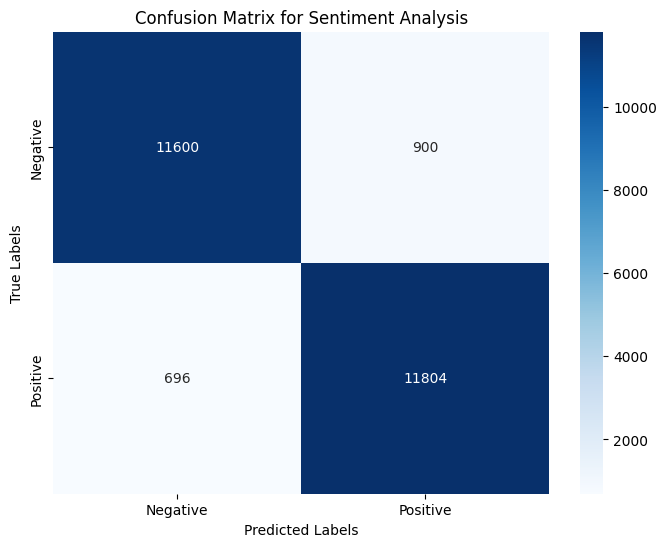

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels for better readability
class_names = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()


Predicting the sentiment of new, unseen text examples.

In [9]:
import torch
import torch.nn.functional as F

# Example sentences for prediction
example_sentences = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "It was a complete waste of time, I would not recommend it.",
    "The acting was good, but the plot was a bit slow.",
    "An amazing cinematic experience, truly captivating.",
    "So boring, I almost fell asleep multiple times."
]

# Move model to evaluation mode
model.eval()

print("Making predictions...")
predictions_output = []

for sentence in example_sentences:
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities by applying softmax to logits
    probabilities = F.softmax(outputs.logits, dim=-1)
    predicted_class_id = torch.argmax(probabilities, dim=-1).item()

    # Map class ID to sentiment label (0: Negative, 1: Positive)
    sentiment_label = "Positive" if predicted_class_id == 1 else "Negative"

    # Get the probability of the predicted class
    predicted_probability = probabilities[0, predicted_class_id].item()

    predictions_output.append({
        "sentence": sentence,
        "predicted_sentiment": sentiment_label,
        "probability": predicted_probability
    })

# Print predictions
for pred in predictions_output:
    print(f"\nSentence: {pred['sentence']}")
    print(f"Predicted Sentiment: {pred['predicted_sentiment']} (Probability: {pred['probability']:.4f})")

print("Predictions complete.")

Making predictions...

Sentence: This movie was absolutely fantastic! I loved every minute of it.
Predicted Sentiment: Positive (Probability: 0.9982)

Sentence: It was a complete waste of time, I would not recommend it.
Predicted Sentiment: Negative (Probability: 0.9994)

Sentence: The acting was good, but the plot was a bit slow.
Predicted Sentiment: Positive (Probability: 0.8699)

Sentence: An amazing cinematic experience, truly captivating.
Predicted Sentiment: Positive (Probability: 0.9982)

Sentence: So boring, I almost fell asleep multiple times.
Predicted Sentiment: Negative (Probability: 0.9990)
Predictions complete.
